In [10]:
import json

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from tqdm import tqdm

In [11]:
metadata = pl.read_parquet(
    "/kaggle/input/uspto-boolean-search-optimization/patent_metadata.parquet"
)
print(metadata.shape)
metadata.head(2)

(13307751, 5)


publication_number,publication_date,filing_date,family_id,cpc_codes
str,datetime[μs],datetime[μs],f64,list[str]
"""US-1-A""",1836-07-13 00:00:00,null,2.060279e6,"[""B61C11/04""]"
"""US-1-P""",1931-08-18 00:00:00,1930-08-06 00:00:00,4.9893162e7,"[""A01H5/02"", ""A01H6/749""]"


In [12]:
with open("/kaggle/input/patent2parquet/patent2parquet.json", "r") as f:
    patent2parquet = json.load(f)

patent2parquet = pl.DataFrame({"publication_number": list(patent2parquet.keys())})
print(patent2parquet.shape)
patent2parquet.head(2)

(13307658, 1)


publication_number
str
"""US-1203561-A"""
"""US-1203562-A"""


In [13]:
nn_df = pl.read_csv("/kaggle/input/uspto-boolean-search-optimization/nearest_neighbors.csv")
print(nn_df.shape)
nn_df.head(2)

(13307647, 51)


publication_number,neighbor_0,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,neighbor_8,neighbor_9,neighbor_10,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,neighbor_21,neighbor_22,neighbor_23,neighbor_24,neighbor_25,neighbor_26,neighbor_27,neighbor_28,neighbor_29,neighbor_30,neighbor_31,neighbor_32,neighbor_33,neighbor_34,neighbor_35,neighbor_36,neighbor_37,neighbor_38,neighbor_39,neighbor_40,neighbor_41,neighbor_42,neighbor_43,neighbor_44,neighbor_45,neighbor_46,neighbor_47,neighbor_48,neighbor_49
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""US-1-A""","""US-189152-A""","""US-1189501-A""","""US-409430-A""","""US-421894-A""","""US-9052-A""","""US-435641-A""","""US-247802-A""","""US-566579-A""","""US-148439-A""","""US-488484-A""","""US-1003894-A""","""US-951842-A""","""US-965846-A""","""US-733217-A""","""US-1681171-A""","""US-339-A""","""US-1206147-A""","""US-1213323-A""","""US-9716-A""","""US-882618-A""","""US-1161812-A""","""US-6321-A""","""US-3267876-A""","""US-1136947-A""","""US-1097810-A""","""US-939423-A""","""US-986261-A""","""US-975048-A""","""US-95968-A""","""US-5532-A""","""US-393896-A""","""US-156138-A""","""US-144271-A""","""US-357649-A""","""US-1182286-A""","""US-1342938-A""","""US-1329037-A""","""US-42039-A""","""US-3237572-A""","""US-462944-A""","""US-1108807-A""","""US-1393935-A""","""US-45450-A""","""US-381847-A""","""US-1354714-A""","""US-661045-A""","""US-737513-A""","""US-447255-A""","""US-1510390-A""","""US-1075814-A"""
"""US-1-P""","""US-93-P""","""US-5247-P""","""US-4994-P""","""US-79-P""","""US-32-P""","""US-1997369-A""","""US-10157-P""","""US-5287-P""","""US-PP13497-P2""","""US-10575-P""","""US-4626-P""","""US-5307-P""","""US-2202966-A""","""US-PP13458-P2""","""US-4462-P""","""US-PP28503-P3""","""US-4274-P""","""US-7619-P""","""US-PP12859-P2""","""US-PP20477-P3""","""US-PP16660-P3""","""US-4953-P""","""US-PP12171-P2""","""US-PP27118-P3""","""US-1975536-A""","""US-PP29050-P2""","""US-4761-P""","""US-PP30184-P2""","""US-4489-P""","""US-2013239269-…","""US-7003-P""","""US-4702-P""","""US-4724-P""","""US-4979-P""","""US-7731-P""","""US-PP28543-P3""","""US-7882-P""","""US-PP21792-P3""","""US-PP31404-P3""","""US-PP28469-P3""","""US-11160-P""","""US-PP27772-P3""","""US-4163-P""","""US-PP13496-P2""","""US-10448-P""","""US-5873-P""","""US-PP23739-P3""","""US-PP21937-P2""","""US-6339-P""","""US-10059-P"""


In [19]:
test = pl.read_csv("/kaggle/input/uspto-boolean-search-optimization/test.csv")
print(test.shape)
test_patents = set(sum(test.to_numpy().tolist(), []))
test.head(2)

(10, 51)


publication_number,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,target_35,target_36,target_37,target_38,target_39,target_40,target_41,target_42,target_43,target_44,target_45,target_46,target_47,target_48,target_49
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""US-2017082634-…","""US-2020225242-…","""US-2010137151-…","""US-10607721-B2…","""US-6747273-B2""","""US-6940065-B2""","""US-7684934-B2""","""US-2019018928-…","""US-9040903-B2""","""US-7847245-B2""","""US-8501421-B2""","""US-9110076-B2""","""US-10617717-B2…","""US-8741556-B2""","""US-9312110-B2""","""US-7865312-B2""","""US-11428696-B2…","""US-11646185-B2…","""US-7603240-B2""","""US-9879304-B2""","""US-9354236-B2""","""US-2022365028-…","""US-2014051105-…","""US-2021239708-…","""US-10825672-B2…","""US-2022397578-…","""US-9746477-B2""","""US-2022221467-…","""US-2016139140-…","""US-2019353660-…","""US-9110074-B2""","""US-8604692-B2""","""US-2017168055-…","""US-7499807-B1""","""US-2003008327-…","""US-2003166007-…","""US-10598642-B2…","""US-10401337-B2…","""US-2005221500-…","""US-2017023547-…","""US-2003157575-…","""US-10197576-B2…","""US-11011359-B2…","""US-7020559-B1""","""US-8642349-B1""","""US-2009253156-…","""US-7783429-B2""","""US-2003060983-…","""US-10914740-B2…","""US-7858389-B2""","""US-9747412-B2"""
"""US-2017180470-…","""US-2017171349-…","""US-2017171301-…","""US-2017155712-…","""US-2017163642-…","""US-2017155740-…","""US-2017180760-…","""US-2017155927-…","""US-2014289307-…","""US-9550119-B2""","""US-2017163478-…","""US-9280384-B2""","""US-2017155928-…","""US-2017163479-…","""US-10798147-B2…","""US-2017171150-…","""US-11582325-B2…","""US-11057489-B2…","""US-2017150214-…","""US-10182126-B2…","""US-9456024-B1""","""US-2017155695-…","""US-2017163706-…","""US-2021234919-…","""US-2014073370-…","""US-10075387-B1…","""US-2012005274-…","""US-8180857-B2""","""US-2017171566-…","""US-11432171-B2…","""US-2018227220-…","""US-10231269-B2…","""US-2017163761-…","""US-2017180468-…","""US-2022263759-…","""US-11582153-B2…","""US-2019245912-…","""US-2021389960-…","""US-2017171147-…","""US-10958580-B2…","""US-10897506-B2…","""US-11586626-B1…","""US-10945130-B2…","""US-2023041645-…","""US-2014310385-…","""US-9749174-B1""","""US-2014344473-…","""US-2017142196-…","""US-9276860-B2""","""US-2017149934-…","""US-2017153909-…"


In [ ]:
# ベン図
meta_patents = set(metadata["publication_number"].to_numpy())
nn_patents = set(nn_df["publication_number"].to_numpy())
parquet_patents = set(patent2parquet["publication_number"].to_numpy())

In [39]:
with open("/kaggle/input/uspto-boolean-search-optimization/train_index_patent_ids.json", "r") as f:
    train_index_patent_ids = set(json.load(f))

print(len(train_index_patent_ids))

200000


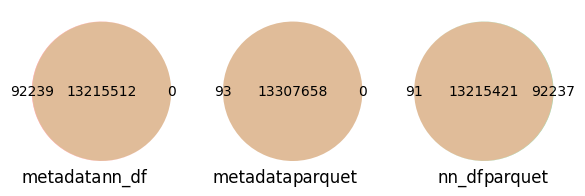

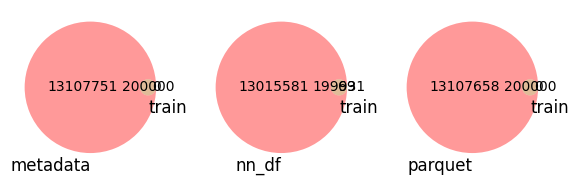

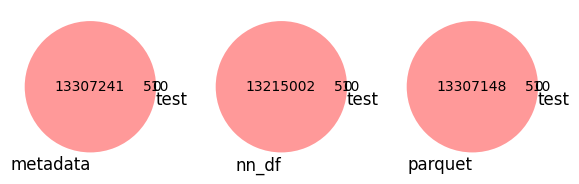

In [40]:
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

fig, axs = plt.subplots(1, 3, figsize=(6, 30))
axs = axs.flatten()
venn = venn2(
    [meta_patents, nn_patents],
    set_labels=("metadata", "nn_df"),
    ax=axs[0],
)

venn = venn2(
    [meta_patents, parquet_patents],
    set_labels=("metadata", "parquet"),
    ax=axs[1],
)

venn = venn2(
    [nn_patents, parquet_patents],
    set_labels=("nn_df", "parquet"),
    ax=axs[2],
)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(6, 30))
axs = axs.flatten()
venn = venn2(
    [meta_patents, train_index_patent_ids],
    set_labels=("metadata", "train"),
    ax=axs[0],
)

venn = venn2(
    [nn_patents, train_index_patent_ids],
    set_labels=("nn_df", "train"),
    ax=axs[1],
)

venn = venn2(
    [parquet_patents, train_index_patent_ids],
    set_labels=("parquet", "train"),
    ax=axs[2],
)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(6, 30))
axs = axs.flatten()
venn = venn2(
    [meta_patents, test_patents],
    set_labels=("metadata", "test"),
    ax=axs[0],
)

venn = venn2(
    [nn_patents, test_patents],
    set_labels=("nn_df", "test"),
    ax=axs[1],
)

venn = venn2(
    [parquet_patents, test_patents],
    set_labels=("parquet", "test"),
    ax=axs[2],
)
plt.tight_layout()
plt.show()

200000


In [36]:
train_index_patent_ids

['US-10000095-B2',
 'US-10000099-B2',
 'US-10000109-B2',
 'US-10000176-B2',
 'US-10000181-B2',
 'US-10000237-B2',
 'US-10000245-B2',
 'US-10000313-B2',
 'US-10000398-B2',
 'US-10000407-B2',
 'US-10000424-B2',
 'US-10000458-B2',
 'US-10000708-B2',
 'US-10000709-B2',
 'US-10000746-B2',
 'US-10000823-B2',
 'US-10000837-B2',
 'US-10000840-B2',
 'US-10001025-B2',
 'US-10001049-B2',
 'US-10001089-B2',
 'US-10001352-B1',
 'US-10001358-B2',
 'US-10001386-B2',
 'US-10001566-B2',
 'US-10001640-B1',
 'US-10001648-B2',
 'US-10001715-B2',
 'US-10001802-B2',
 'US-10001808-B1',
 'US-10001955-B2',
 'US-10002017-B2',
 'US-10002202-B2',
 'US-10002215-B2',
 'US-10002364-B2',
 'US-10002464-B1',
 'US-10002525-B2',
 'US-10002604-B2',
 'US-10002673-B2',
 'US-10002695-B2',
 'US-10002842-B2',
 'US-10002848-B1',
 'US-10002974-B2',
 'US-10003105-B2',
 'US-10003108-B2',
 'US-10003133-B2',
 'US-10003183-B2',
 'US-10003295-B2',
 'US-10003352-B2',
 'US-10003382-B1',
 'US-10003408-B2',
 'US-10003430-B2',
 'US-1000343